In [11]:
#!/usr/bin/env python3

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy.signal import butter, filtfilt


In [19]:
inputDir = '../ADHD_data/ADHD_part1'
outputDir = '../ADHD_data/ADHD_part1_preprocessed'
exampleFileName = 'v1p.mat'  # We'll preprocess this one file as a demo

if not os.path.exists(outputDir):
    os.makedirs(outputDir)

fs = 128  # sampling frequency

# List all .mat files in inputDir
fileList = [f for f in os.listdir(inputDir) if f.endswith('.mat')]
print('Files found in the input directory:')
print(fileList)

# 2) LOAD & INSPECT (exampleFileName)
exampleFilePath = os.path.join(inputDir, exampleFileName)
dataStruct = loadmat(exampleFilePath)

# The actual EEG data is usually in one main variable (e.g. 'v1p')
varNames = [k for k in dataStruct.keys() if not k.startswith('__')]
if not varNames:
    raise ValueError(f"No valid data found in {exampleFileName}.")

rawData = dataStruct[varNames[0]]  # e.g. dataStruct['v1p']

print(f"Loaded example file: {exampleFileName}")
print(f"Data size: {rawData.shape[0]} x {rawData.shape[1]} (rows x cols)")

Files found in the input directory:
['v10p.mat', 'v12p.mat', 'v14p.mat', 'v15p.mat', 'v173.mat', 'v18p.mat', 'v19p.mat', 'v1p.mat', 'v20p.mat', 'v21p.mat', 'v22p.mat', 'v24p.mat', 'v25p.mat', 'v27p.mat', 'v28p.mat', 'v29p.mat', 'v30p.mat', 'v31p.mat', 'v32p.mat', 'v33p.mat', 'v34p.mat', 'v35p.mat', 'v36p.mat', 'v37p.mat', 'v38p.mat', 'v39p.mat', 'v3p.mat', 'v40p.mat', 'v6p.mat', 'v8p.mat']
Loaded example file: v1p.mat
Data size: 12258 x 19 (rows x cols)


Transposed data to channels x time.
Final data shape: 19 x 12258 (channels x time)


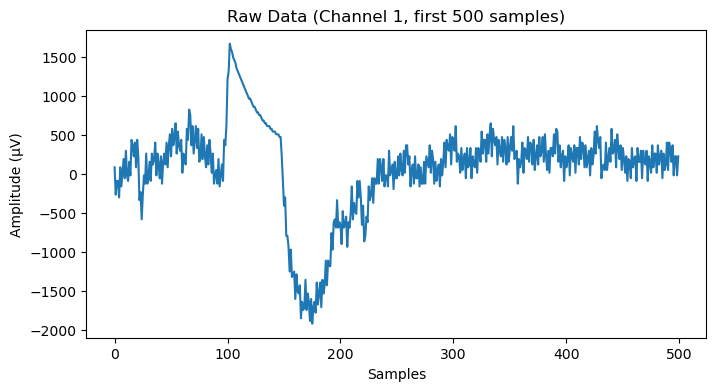

In [20]:
if rawData.shape[0] > rawData.shape[1]:
    rawData = rawData.T
    print("Transposed data to channels x time.")

channels, timePoints = rawData.shape
print(f"Final data shape: {channels} x {timePoints} (channels x time)")

# 4) PLOT RAW DATA (first 500 samples, channel 1)
plt.figure(figsize=(8,4))
maxSamples = min(500, timePoints)
plt.plot(rawData[0, :maxSamples])  # Channel 1 => index 0
plt.title("Raw Data (Channel 1, first 500 samples)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.show()

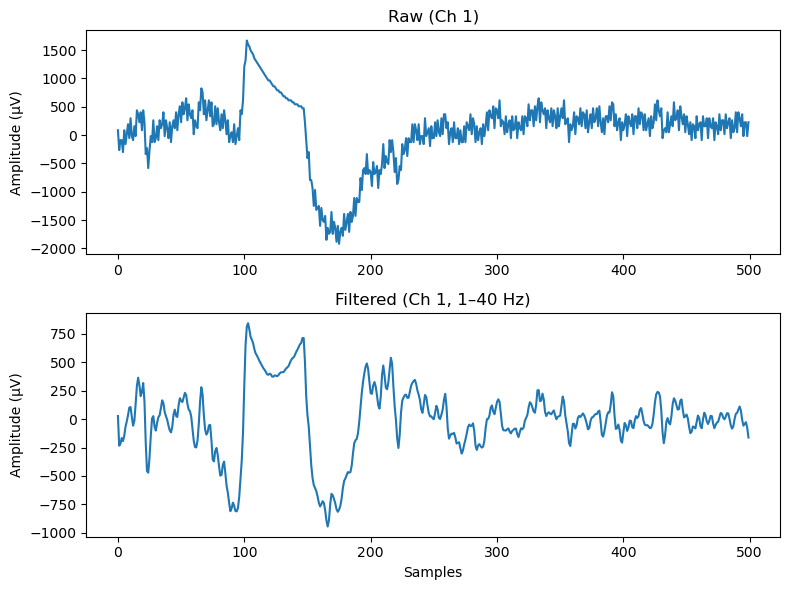

In [21]:
lowCut = 1.0
highCut = 40.0
desiredOrder = 4
minLengthForFilter = 3 * (2 * desiredOrder)  # 3*(2*filterOrder) for filtfilt

if timePoints < minLengthForFilter:
    print(f"WARNING: Data length ({timePoints}) < {minLengthForFilter}. Skipping filter.")
    filteredData = rawData.copy()
else:
    # Design Butterworth filter
    b, a = butter(desiredOrder, [lowCut/(fs/2), highCut/(fs/2)], btype='band')
    filteredData = np.zeros_like(rawData)
    for ch in range(channels):
        filteredData[ch, :] = filtfilt(b, a, rawData[ch, :])

# Compare raw vs. filtered on channel 1
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(rawData[0, :maxSamples])
plt.title("Raw (Ch 1)")
plt.ylabel("Amplitude (µV)")

plt.subplot(2,1,2)
plt.plot(filteredData[0, :maxSamples])
plt.title("Filtered (Ch 1, 1–40 Hz)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.tight_layout()
plt.show()

Number of artifact samples flagged: 1481


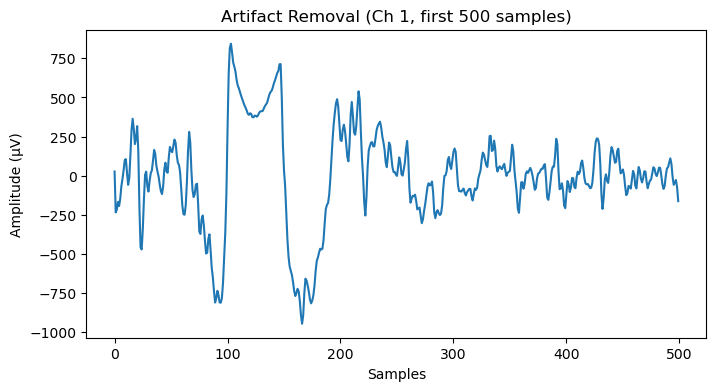

In [25]:
artifactThreshold = 1000.0
artifactMask = np.abs(filteredData) > artifactThreshold
numArtifacts = np.sum(artifactMask)
print(f"Number of artifact samples flagged: {numArtifacts}")

cleanedData = filteredData.copy().astype(float)
cleanedData[artifactMask] = np.nan

# Plot snippet with artifacts removed
plt.figure(figsize=(8,4))
ch1Snippet = cleanedData[0, :maxSamples]
plt.plot(ch1Snippet)
plt.title("Artifact Removal (Ch 1, first 500 samples)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.show()

Normalized Ch1 -> mean=0.000, std=0.992


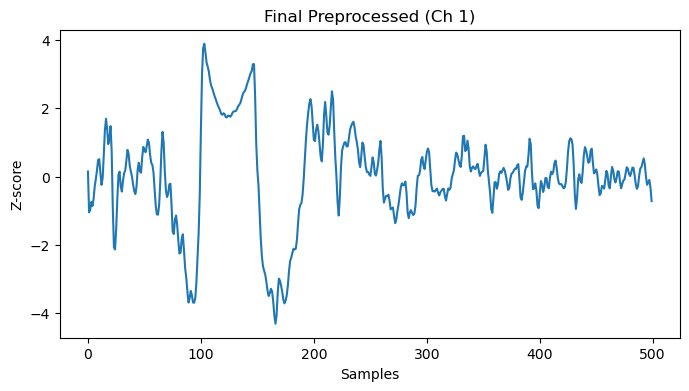

In [27]:
normalizedData = np.zeros_like(cleanedData)
for ch in range(channels):
    chanData = cleanedData[ch, :]
    goodIdx = ~np.isnan(chanData)
    if np.any(goodIdx):
        mu = np.mean(chanData[goodIdx])
        sigmaVal = np.std(chanData[goodIdx])
        if sigmaVal < 1e-10:
            sigmaVal = 1.0  # avoid div by zero
        normalizedData[ch, goodIdx] = (chanData[goodIdx] - mu) / sigmaVal
    else:
        # If entire channel is NaN, fill with NaN
        normalizedData[ch, :] = np.nan
# Quick check on channel 1 distribution
ch1Good = normalizedData[0, ~np.isnan(normalizedData[0, :])]
meanCh1 = np.mean(ch1Good) if len(ch1Good) else float('nan')
stdCh1  = np.std(ch1Good)  if len(ch1Good) else float('nan')
print(f"Normalized Ch1 -> mean={meanCh1:.3f}, std={stdCh1:.3f}")

# Plot final snippet
plt.figure(figsize=(8,4))
plt.plot(normalizedData[0, :maxSamples])
plt.xlabel("Samples")
plt.ylabel("Z-score")
plt.title("Final Preprocessed (Ch 1)")
plt.show()